# Create Multi Needle In A Haystack Visualization

Let's run through how to create the visualization for the Multi Needle In A Hackstack Test.

At a highlevel, it's a two step process
1. Read your results (e.g., from LangSmith dataset or local)
2. Plot your % retrieved with respect to contet length (as done in Gemini 1.5 [paper](https://storage.googleapis.com/deepmind-media/gemini/gemini_v1_5_report.pdf))
4. Optionally plot retrieval with respect to position for each needle

## Get results from eval sets

`eval_sets_retrieval`

* https://smith.langchain.com/public/af0f1c89-3993-4ded-91c2-29eebef67582/d
* https://smith.langchain.com/public/d6b47e6e-8279-4452-bd22-d6c8b839f1a0/d
* https://smith.langchain.com/public/74d2af1c-333d-4a73-87bc-a837f8f0f65c/d

`eval_sets_reasoning`

* https://smith.langchain.com/public/a85db85f-ee45-4a39-a1ac-52f7279134ac/d
* https://smith.langchain.com/public/270cd9cd-154d-4ba9-8b34-7b6537007867/d
* https://smith.langchain.com/public/00658b64-6199-48fc-9443-1478aadbe19a/d

In [361]:
# Eval set name for LangSmith
eval_sets_retrieval = ["multi-needle-eval-pizza-1",
                       "multi-needle-eval-pizza-3",
                       "multi-needle-eval-pizza-10"]

eval_sets_reasoning = ["multi-needle-eval-pizza-reasoning-1",
                       "multi-needle-eval-pizza-reasoning-3",
                       "multi-needle-eval-pizza-reasoning-10"]

In [362]:
import pandas as pd 
from langsmith.client import Client

# Get all runs for a given eval set
client = Client()

def get_data(eval_sets):

    # Store
    all_data = []
    
    # Iterate through eval sets 
    for set in eval_sets:
    
        # All runs for the given eval set
        projects = client.list_projects(reference_dataset_name=set)
        
        # Iterate through the runs on the eval set
        for p in projects:

            # TODO: Clear commenting here 
            project = client.read_project(project_name=p.name)
            runs = list(client.list_runs(project_id=project.id, execution_order=1))
            if client.run_is_shared(run_id=runs[0].id):
                url = client.read_run_shared_link(runs[0].id)    
            else:
                url = client.share_run(run_id=runs[0].id)   
            trace = client.get_test_results(project_name=p.name)
            generation = trace.loc[0,'outputs.output.content']
            # Extract the desired information from each project
            data = {
                'run_name': project.name,
                'run_url': url,
                'depth %': project.metadata['depth_percent'],
                'context length': project.metadata['context_length'],
                'retrieved needles': project.feedback_stats['needles_retrieved']['avg'],
                'model name': project.metadata['model_name'],
                'total needles': project.metadata['num_needles'],
                'answer': generation,
                'needles': project.metadata['needles'],
                'insertion_percentages': project.metadata['insertion_percentages']
            }
            # Add the data dictionary to the list
            all_data.append(data)
            
    
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(all_data)
    df.set_index("run_name",inplace=True)
    df['percent'] = df['retrieved needles'] / df['total needles'] 
    return df

In [ ]:
df = get_data(eval_sets_retrieval)
df_reasoning = get_data(eval_sets_reasoning)

## Manul audit

* Ensure that the grader is sane.
* Degredation in ability to count needles at 10.
* Moving to > 10 needles would require considerable auditing.

In [370]:
df.loc["90250-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--b3a1","retrieved needles"]=6 # graded as 5
df.loc["60500-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--23a0","retrieved needles"]=6 # graded as 5
df.loc["60500-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--7272","retrieved needles"]=6 # graded as 5
df.loc["60500-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--5f4d","retrieved needles"]=6 # graded as 5
df.loc["30750-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--84a2","retrieved needles"]=6 # graded as 5

## Aggregate

Aggregate replicates for each combination of `total needles`, `model name`, `context length`

In [371]:
def group(df):
    agg_df = df.groupby(['total needles', 'model name', 'context length']).agg(
        mean=('retrieved needles', lambda x: x.sum() / df.loc[x.index, 'total needles'].sum()),  # Using lambda for direct calculation
        mean_percent=('percent', 'mean'),  # Directly use 'mean' since 'percent' is already calculated
        urls=('run_url', lambda x: list(x)[:3])).reset_index()
    return agg_df

agg_df = group(df)
agg_df_reasoning = group(df_reasoning)

## Plot % needles retrieved

With respect to:

* context length
* number of needles

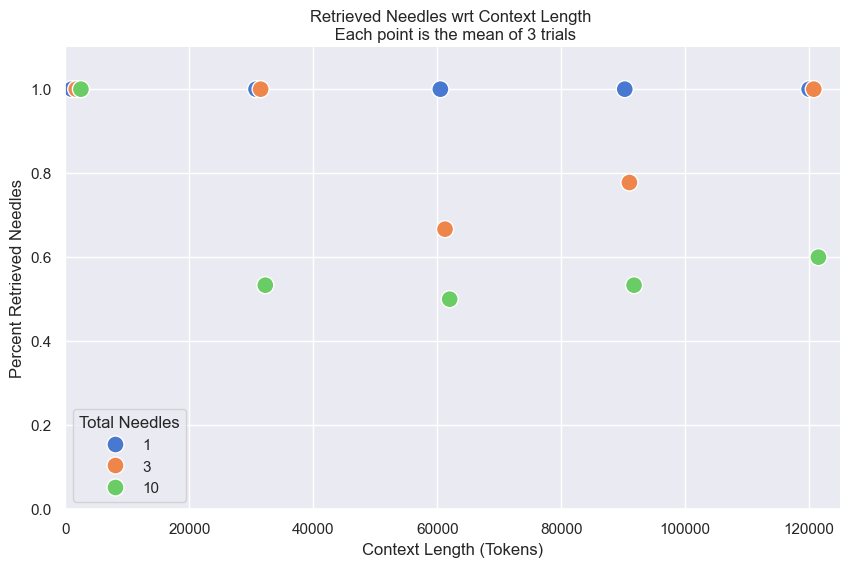

In [385]:
def plot(df,model,plot_col):

    # Setting the theme
    sns.set_theme(style="darkgrid" )

    # Select a model
    df = df[df["model name"]==model].copy()

    # Function to add fixed offset based on 'total needles'
    def add_fixed_offset(series, base_offset):
        # Apply fixed offset
        offset_series = series.apply(lambda x: x * base_offset)
        return offset_series
    
    # Calculate a fixed offset for 'context length' based on 'total needles'
    base_offset = 1500  # Base offset value, adjust based on your visual and data needs
    df['context length offset'] = add_fixed_offset(df['total needles'], base_offset)

    # Sort and map 'total needles' to a fixed offset based on order
    unique_needles_sorted = sorted(df['total needles'].unique())
    offset_map = {val: i * 750 for i, val in enumerate(unique_needles_sorted)}  # 750 is the base offset
    
    # Apply the fixed offset based on 'total needles' order
    df['context length offset'] = df['total needles'].map(offset_map)
    
    # Adjust 'context length' to include the calculated offset
    df['context length jittered'] = df['context length'] + df['context length offset']
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, 
                    x="context length jittered", 
                    y=plot_col, 
                    hue="total needles", 
                    palette=sns.color_palette("muted", 3),
                    s=150,
                    edgecolor='white', 
                    linewidth=1)  # Added edgecolor and linewidth for outline
    sns.despine()
    
    # Adding labels and title for clarity
    plt.xlabel("Context Length (Tokens)")
    plt.ylabel("Percent Retrieved Needles")
    plt.title("Retrieved Needles wrt Context Length \n Each point is the mean of 3 trials")
    plt.legend(title='Total Needles')
    
    # Display the plot
    plt.xlim([-50,125000])
    plt.ylim([0,1.1])
    plt.show()

    return df

d = plot(agg_df,"gpt-4-0125-preview","mean_percent")

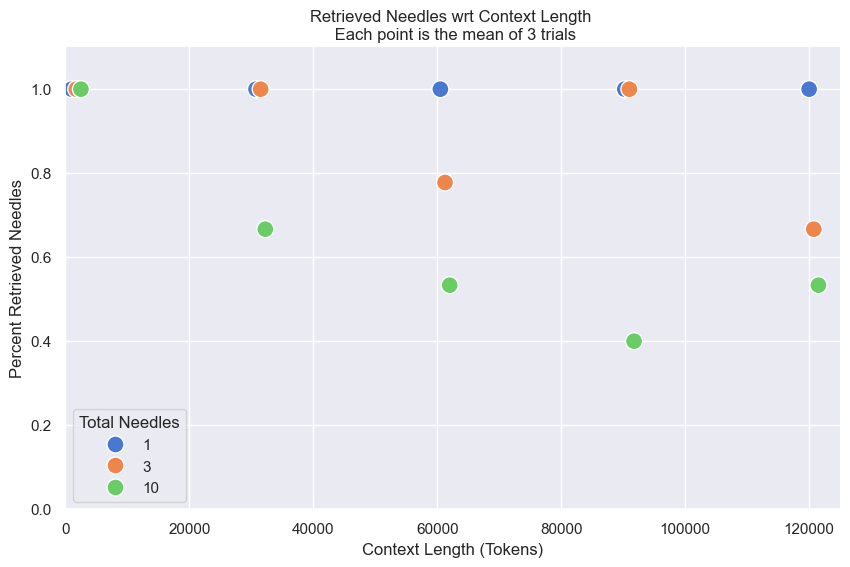

In [386]:
d = plot(agg_df_reasoning,"gpt-4-0125-preview","mean_percent")

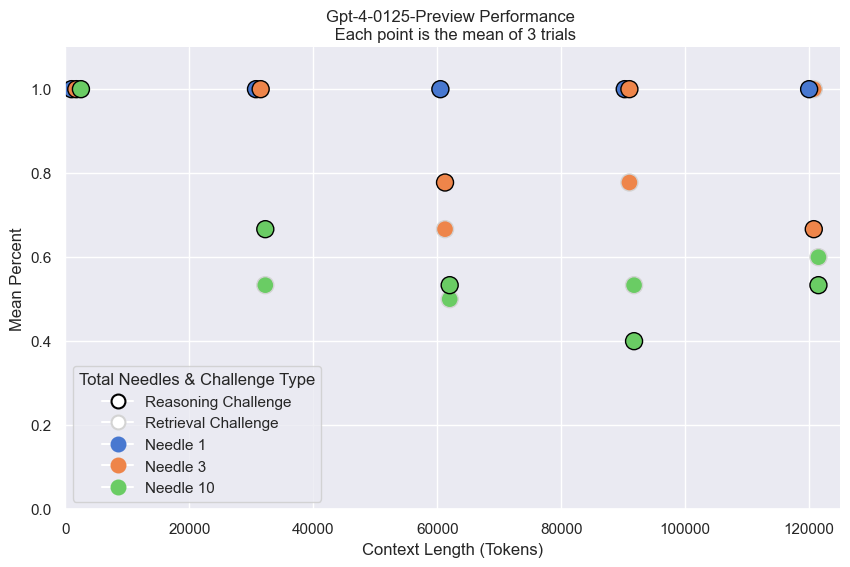

In [396]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.lines as mlines

def plot_combine(df, model, plot_col):
    # Setting the theme
    sns.set_theme(style="darkgrid")

    # Select a model
    df = df[df["model name"] == model].copy()

    # Adjust 'context length' to include a fixed offset based on 'total needles'
    unique_needles_sorted = sorted(df['total needles'].unique())
    offset_map = {val: i * 750 for i, val in enumerate(unique_needles_sorted)}
    df['context length offset'] = df['total needles'].map(offset_map)
    
    # Adjust 'context length' to include the calculated offset
    df['context length jittered'] = df['context length'] + df['context length offset']
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Define colors for edge based on challenge type
    edge_colors = {'reasoning': 'black', 'retrieval': '#d3d3d3'}  # light gray for retrieval
    
    # Iterate over each unique value in 'challenge' to plot separately, allowing for custom edge color
    palette = sns.color_palette("muted", len(unique_needles_sorted))
    for challenge in df['challenge'].unique():
        subset = df[df['challenge'] == challenge]
        sns.scatterplot(data=subset, 
                        x="context length jittered", 
                        y=plot_col, 
                        hue="total needles", 
                        palette=palette,
                        s=150,
                        edgecolor=edge_colors[challenge], 
                        linewidth=1)

    sns.despine()
    
    # Adding labels and title for clarity
    plt.xlabel("Context Length (Tokens)")
    plt.ylabel(plot_col.replace('_', ' ').title())
    plt.title(f"{model.title()} Performance \n Each point is the mean of 3 trials")
    
    # Create custom legend for challenge type
    reasoning_patch = mlines.Line2D([], [], color='w', markerfacecolor='w', marker='o',
                                     markersize=10, label='Reasoning Challenge', markeredgewidth=1.5,
                                     markeredgecolor='black')
    retrieval_patch = mlines.Line2D([], [], color='w', markerfacecolor='w', marker='o',
                                     markersize=10, label='Retrieval Challenge', markeredgewidth=1.5,
                                     markeredgecolor='#d3d3d3')  # light gray edge

    needle_1_patch = mlines.Line2D([], [], color='w', markerfacecolor=palette[0], marker='o',
                                     markersize=10, label='Needle 1', markeredgewidth=1.5,
                                     markeredgecolor=palette[0])  # light gray edge

    needle_3_patch = mlines.Line2D([], [], color='w', markerfacecolor=palette[1], marker='o',
                                     markersize=10, label='Needle 3', markeredgewidth=1.5,
                                     markeredgecolor=palette[1])  # light gray edge

    needle_10_patch = mlines.Line2D([], [], color='w', markerfacecolor=palette[2], marker='o',
                                     markersize=10, label='Needle 10', markeredgewidth=1.5,
                                     markeredgecolor=palette[2])  # light gray edge
    
    handles=[reasoning_patch, retrieval_patch, needle_1_patch, needle_3_patch, needle_10_patch]
    
    # Adjust plot limits, show combined legend, and display the plot
    plt.xlim([-50, 125000])
    plt.ylim([0, 1.1])
    plt.legend(handles=handles, title='Total Needles & Challenge Type')
    plt.show()

    return df

# Combine
agg_df['challenge']='retrieval'
agg_df_reasoning['challenge']='reasoning'
df_all=pd.concat([agg_df,agg_df_reasoning],axis=0)
d = plot_combine(df_all, "gpt-4-0125-preview", "mean_percent")

## Needle position 

In [457]:
# Initialize an empty list to collect the results from all rows in df_model
all_results = []

# Iterate over each row in df_model
for index, row in df_logged.iterrows():
    
    needle_texts = row['needles']
    
    # Extracting just the ingredient names from each sentence in "needle text"
    needle_points = [sentence.strip().strip().replace(" is one of the secret ingredients needed to build the perfect pizza.", "").replace(" are the secret ingredient needed to build the perfect pizza.", "").replace(" are one of the secret ingredients needed to build the perfect pizza.", "") for sentence in needle_texts]
    
    # Get the "answer" from the row in "df_model"
    llm_answer = row['answer'] 
    
    # Check which needle points are in the answer
    context_size = row['context length']
    run_name = row['run_url']  
    total_needles = row['total needles']  
    run_url = row['run_url']  
    insertion_percentages = row['insertion_percentages']
    
    for needle, insertion_percent in zip(needle_points, insertion_percentages):
        present = 1 if needle.lower() in llm_answer.lower() else 0
        all_results_logged.append({
            'needle': needle,
            'needle point': needle,
            'insertion %': insertion_percent,
            'context size': context_size,
            'present in the answer': present,
            'total_needles':total_needles,
            'run name': run_name,
            'run_url': run_url
        })

# Convert the collected list of dictionaries to a DataFrame
results_df = pd.DataFrame(all_results)

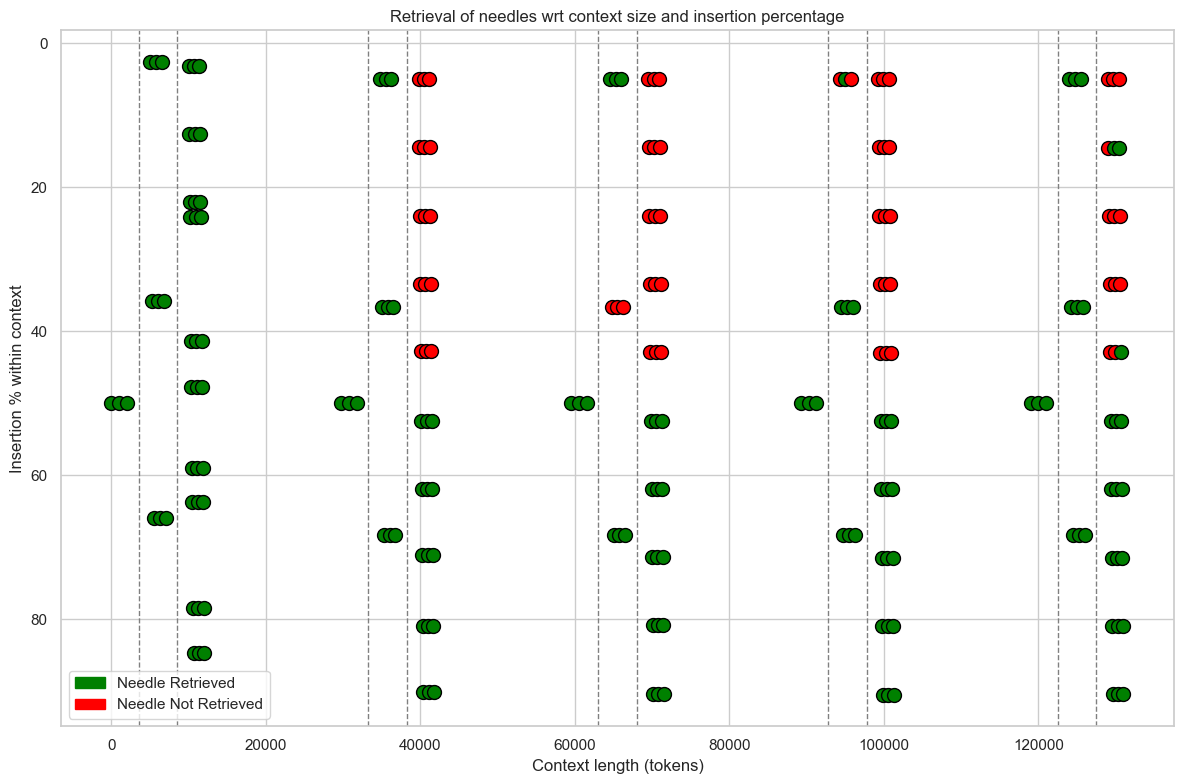

In [462]:
import matplotlib.patches as mpatches

def plt_multi_needle_scatter(results_df):

    # Set the seaborn style
    sns.set(style="whitegrid")
    
    # Prepare the plot
    plt.figure(figsize=(12, 8))
    
    # Unique context sizes and total needles values for offset calculation
    context_sizes = sorted(results_df['context size'].unique())
    total_needles_values = sorted(results_df['total_needles'].unique())
    
    # Base offset between different total_needles groups to ensure they are spaced apart
    group_base_offset = 5000
    point_size = 100  # Increase the point size
    edge_color = 'black'  # Border color
    
    # Plot each point with the specified logic
    for context_size in context_sizes:
        for j, total_needles in enumerate(total_needles_values):
            # Filter data for current context size and total needles
            subset = results_df[(results_df['context size'] == context_size) & (results_df['total_needles'] == total_needles)]
            
            if not subset.empty:
                # Calculate dynamic offsets within each total_needles group for replicates
                dynamic_offsets_within_group = np.linspace(-1000, 1000, num=max(len(subset), 3))  # Ensure space for at least 3 replicates
                
                for k, (index, row) in enumerate(subset.iterrows()):
                    color = 'green' if row['present in the answer'] == 1 else 'red'
                    # Calculate final offset for each point
                    final_offset = (j * group_base_offset) + dynamic_offsets_within_group[k]
                    plt.scatter(context_size + final_offset, row['insertion %'], s=point_size, color=color, edgecolor=edge_color, linewidth=1)
    
        # Add vertical dashed lines between groups for each context size
        for i in range(1, len(total_needles_values)):
            line_position = context_size + (i * group_base_offset) - (group_base_offset / 2)
            plt.axvline(x=line_position, color='grey', linestyle='--', linewidth=1)
    
    # Customize the plot
    plt.xlabel("Context length (tokens)")
    plt.ylabel("Insertion % within context")
    plt.title("Retrieval of needles wrt context size and insertion percentage")
    
    # Flip the y-axis
    plt.gca().invert_yaxis()
    
    # Define custom legend
    green_patch = mpatches.Patch(color='green', label='Needle Retrieved')
    red_patch = mpatches.Patch(color='red', label='Needle Not Retrieved')
    plt.legend(handles=[green_patch, red_patch], loc='lower left')
    
    plt.tight_layout()
    # Save the figure
    plt.savefig("plot_needle_retrieval.png", dpi=300, bbox_inches='tight')
    plt.show()

plt_multi_needle_scatter(results_df)